# Dynamic LCA with Temporalis

In [1]:
import bw2temporalis as bwt
import brightway2 as bw
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline

In [6]:
if "temporalis-demo" in bw.projects:
    bw.projects.delete_project("temporalis-demo", True)
bw.projects.set_current("temporalis-demo")

In [7]:
bw.add_example_database()

Writing activities to SQLite3 database:


Extracted 3 worksheets in 0.02 seconds
Applying strategy: csv_restore_tuples
Applying strategy: csv_restore_booleans
Applying strategy: csv_numerize
Applying strategy: csv_drop_unknown
Applying strategy: csv_add_missing_exchanges_section
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: assign_only_product_as_production
Applying strategy: drop_falsey_uncertainty_fields_but_keep_zeros
Applying strategy: convert_uncertainty_types_to_integers
Applying strategy: convert_activity_parameters_to_list
Applied 11 strategies in 0.00 seconds
Applying strategy: link_iterable_by_fields


0% [#########] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 03/12/2020 20:25:22
  Finished: 03/12/2020 20:25:22
  Total time elapsed: 00:00:00
  CPU %: 105.50
  Memory %: 1.05
Created database: Mobility example


Create a simple LCIA method

In [8]:
bw.databases

Databases dictionary with 1 object(s):
	Mobility example

In [9]:
for x in bw.Database("Mobility example"):
    print(x.key, x)

('Mobility example', 'edb43eb8b3e187759b38c55ae4228ffc') 'Electric car' (unit, GLO, ('Electric car',))
('Mobility example', '7fabbb483617d7a9325f7dee36a11562') 'Electric car battery' (unit, GLO, ('Electric car battery',))
('Mobility example', '6f233d5e001dc3ea41b1a53bbb815521') 'Combustion car' (unit, GLO, ('Combustion car',))
('Mobility example', 'Driving an combustion car') 'Driving an combustion car' (kilometer, Europe, None)
('Mobility example', 'Lithium') 'Lithium' (kilogram, GLO, None)
('Mobility example', 'Electricity') 'Electricity' (kilowatt hour, GLO, None)
('Mobility example', 'Steel') 'Steel' (kilogram, GLO, None)
('Mobility example', 'b8259b28a1d341003af9a67e435fb079') 'CO2' (kilogram, GLO, ('CO2',))
('Mobility example', 'Driving an electric car') 'Driving an electric car' (kilometer, Europe, None)


In [5]:
bw.databases

Databases dictionary with 3 object(s):
	Mobility example
	biosphere3
	ecoinvent 3.6 cutoff

## Create the temporal inventory database with ecoinvent included
Below create our temporal database which reflect the [following flow diagram](https://bitbucket.org/cardosan/brightway2-temporalis/src/tip/docs/example.svg?at=default&fileviewer=file-view-default). We model the (fictitious) cradle-to-grave life cycle of a wood product use. Other than including several temporal informations we use the ecoinvent activity for forestry which includes impact of forestry interventions as well as the biogenic carbon sequestration from forest.

![](example.svg)

In [8]:
METHANE = ('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5')  # Methane, fossil, air, kg
CO2 = ('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9')      # Carbon dioxide, fossil, kg

In [9]:
data = {
    ('example', 'FU'): { #our functional unit i.e. the use of 1 m3 of wood for 5 years
        'exchanges': [
            {
                'amount': 5,
                'input': ('example', 'Wood Use'),
                'temporal distribution': bwt.TemporalDistribution(np.array([ 0,  1,  2,  3,  4],dtype='timedelta64[Y]') ,np.array([1.0, 1.0, 1.0, 1.0, 1.0])),
                'type': 'technosphere'
            },
        ],
        'name': 'FU',
        'type': 'process'
    },
    ('example', 'Wood Use'): {
        'exchanges': [
            {
                'amount': 0.8,
                'input': ('example', 'Incineration'),
                'type': 'technosphere'
            },
            {
                'amount': 0.2,
                'input': ('example', 'Landfilling'),
                'type': 'technosphere'
            },
            {
                'amount': 1,
                'input': ('example', 'Sawmilling'),
                'type': 'technosphere'
            },
        ],
        'name': 'Wood Use',
        'type': 'process'
    },
    ('example', 'Landfilling'): {
        'exchanges': [
            {
                'amount': 10,
                'input': METHANE,
                'temporal distribution': bwt.TemporalDistribution(np.array([10,20,40,60],dtype='timedelta64[Y]') ,np.array([2.5]*4)), 
                'type': 'biosphere'
            },
        ],
        'name': 'Landfilling',
        'type': 'process'
    },
    ('example', 'Incineration'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Energy production'),
                'type': 'substitution'
            },
            {
                'amount': 30,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Incineration',
        'type': 'process'
    },
    ('example', 'Energy production'): {
        'exchanges': [
            {
                'amount': 4,
                'input': CO2,
                'type': 'biosphere'
            },

        ],
        'name': 'Energy production',
        'type': 'process'
    },
    ('example', 'Sawmilling'): {
        'exchanges': [
            {
                'amount': 1,
                'input': ('example', 'Transport'),
                'temporal distribution': TemporalDistribution(np.array([1],dtype='timedelta64[Y]') ,np.array([1.0])),
                'type': 'technosphere'
            },
        ],
        'name': 'Sawmilling',
        'type': 'process'
    },
    ('example', 'Transport'): {
        'exchanges': [
            {
                'amount': 1.2,
                'input': Database(ei_name).search('\"{}\"'.format(ei_forestry))[0],
                'temporal distribution': TemporalDistribution(np.array([24],dtype='timedelta64[M]') ,np.array([1.2])),
                'type': 'technosphere'
            },
            {
                'amount': 5,
                'input': CO2,
                'type': 'biosphere'
            },
        ],
        'name': 'Transport',
        'type': 'process'
    },

}

db = Database("example")
db.write(data)

Writing activities to SQLite3 database:
0%   100%
[#######] | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 04/16/2018 14:19:47
  Finished: 04/16/2018 14:19:47
  Total time elapsed: 00:00:00
  CPU %: 226.60
  Memory %: 2.11


## Create dynamic LCIA methods

Temporalis has already built-in the method to create some IPCC climate metrics (from 2013 assessment report) like  Radiative Forcing and Global Temperature potential. 
We can install them with the function `create_climate_methods` which will also calculate and create their [worst-case](http://temporalis.readthedocs.io/en/latest/traversal.html#worst-case-approach) characterization factor

In [11]:
if not bwt.dynamic_methods:
    bwt.create_climate_methods()

TypeError: object of type <class 'float'> cannot be safely interpreted as an integer.

## Dynamic LCI
Ok now we can solve our dynamic LCI to obtain a timeline containing biosphere flows and processes responsible for these emissions.  Our (dynamic) functional unit is represented by the use of 1 m3 of wood for 5 years starting from 2015 (the `t0`).

In [11]:
dynamic_lca = DynamicLCA(
    demand={('example', 'FU'): 1}, 
    worst_case_method=('RadiativeForcing', 'worst case'), 
    t0=np.datetime64('2015-01-01')
)
timeline = dynamic_lca.calculate()

Our `timeline` object is a `namedtuple` like:

In [12]:
timeline.raw[:5]

[data_point(dt=datetime.datetime(2016, 1, 1, 5, 49, 12), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2016, 12, 31, 11, 38, 24), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2017, 12, 31, 17, 27, 36), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2018, 12, 31, 23, 16, 48), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0),
 data_point(dt=datetime.datetime(2020, 1, 1, 5, 6), flow=('biosphere3', 'f9749677-9c9f-4678-ab55-c607dfdc2cb9'), ds=('example', 'Transport'), amount=5.0)]

we can look at the biosphere flows emitted

In [13]:
timeline.flows()

{('biosphere3', '0795345f-c7ae-410c-ad25-1845784c75f5'),
 ('biosphere3', '16eeda8a-1ea2-408e-ab37-2648495058dd'),
 ('biosphere3', '20185046-64bb-4c09-a8e7-e8a9e144ca98'),
 ('biosphere3', '349b29d1-3e58-4c66-98b9-9d1a076efd2e'),
 ('biosphere3', '35d1dff5-b535-4628-9826-4a8fce08a1f2'),
 ('biosphere3', '473826ae-125a-4b02-8c8e-c84322491d80'),
 ('biosphere3', '57bdb443-d4a6-423d-8024-959b8261d02e'),
 ('biosphere3', '5f7aad3d-566c-4d0d-ad59-e765f971aa0f'),
 ('biosphere3', '6b1b495b-70ee-4be6-b1c2-3031aa4d6add'),
 ('biosphere3', '6dc1b46f-ee89-4495-95c4-b8a637bcd6cb'),
 ('biosphere3', '70ef743b-3ed5-4a6d-b192-fb6d62378555'),
 ('biosphere3', '78eb1859-abd9-44c6-9ce3-f3b5b33d619c'),
 ('biosphere3', '81305cda-63f1-4c1a-99c6-2c2568550ec4'),
 ('biosphere3', '856c9aa2-c20c-49a8-9417-c71bdb5f17b0'),
 ('biosphere3', '9541a975-800f-4fed-9edf-28f6e411a015'),
 ('biosphere3', 'aa7cac3a-3625-41d4-bc54-33e2cf11ec46'),
 ('biosphere3', 'afd6d670-bbb0-4625-9730-04088a5b035e'),
 ('biosphere3', 'b53d3744-3629-

and the processes

In [14]:
timeline.processes()

{('ecoinvent 3.2 cutoff', 'd63bbaea0bba23c6b9f02b946d1e7bf8'),
 ('example', 'Energy production'),
 ('example', 'Incineration'),
 ('example', 'Landfilling'),
 ('example', 'Transport')}

we can also look at the total environmental intervention for one biosphere flow

In [15]:
timeline.total_amount_for_flow(METHANE)

10.002055753190366

and the total environmental intervention for a specific biosphere flow due to an activity

In [16]:
timeline.total_flow_for_activity(METHANE,('example', 'Landfilling'))

10.0

## Dynamic LCIA

Ok now we can calculate our LCIA impact using a static characterization factor (CF). In this case we as static CF the IPCC GWP included in ecoinvent as example

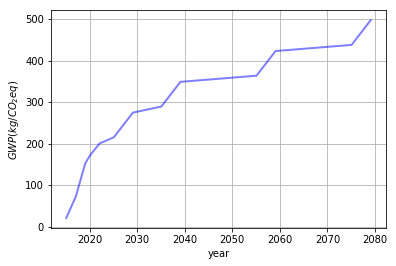

In [17]:
xs, ys  = timeline.characterize_static(('IPCC 2013', 'climate change', 'GWP 100a'))
plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel("$GWP (kg/CO_{2}eq)$")
plt.grid(True)

We will use the Radiative Forcing as example here to calculate both cumulative and instantaneous impacts using a dynamic CF

/home/giuseppec/miniconda3/envs/bw2/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


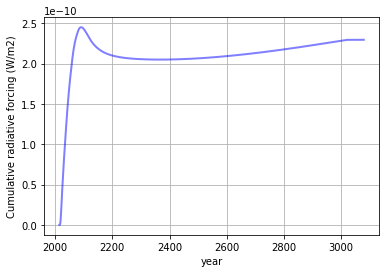

In [18]:
xs, ys  =  timeline.characterize_dynamic("RadiativeForcing",cumulative=True) 

plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(loc="lower left")


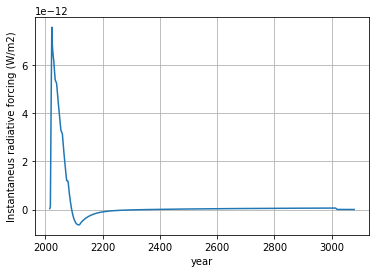

In [19]:
xs, ys  =  timeline.characterize_dynamic("RadiativeForcing",cumulative=False)

plt.plot(xs, ys, linestyle='-')

# Format graph
plt.xlabel("year")
plt.ylabel(r"Instantaneus radiative forcing (W/m2)")
plt.grid(True)

In the implemented dynamic CFs for climate (i.e. also in the graphs above) also the impact due to forest regrowth is taken into account. By default it assumes a rotation lenght of 100 years the instantaneous oxidation of wood modelled as a dirac delta function. We can also change the assumed rotation lenght of the forest stands with parameter `rot_stand`, the number of year after harvesting the biogenic carbon is oxidized with `bio_st_emis_yr` and the function  used to model this oxidation with `bio_st_decay` as shown below

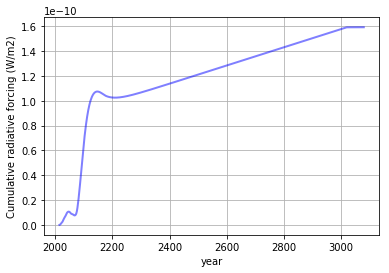

In [20]:
xs, ys  =  timeline.characterize_dynamic("RadiativeForcing",cumulative=True,bio_st_decay='chi2',bio_st_emis_yr=60,rot_stand=150) 

plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

We can also explore the impact due to each single process both using a static and dynamic characterization factor

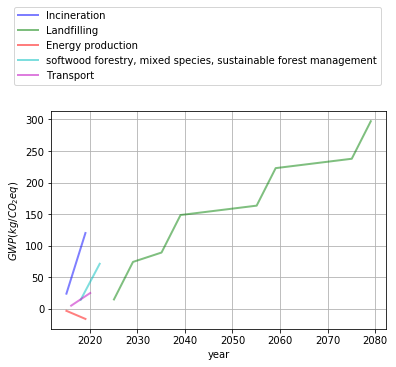

In [21]:
dict_res=timeline.characterize_static_by_process(('IPCC 2013', 'climate change', 'GWP 100a')) #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

for k,v in dict_res.items():  
    plt.plot(v[0], v[1], 'b-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel("$GWP (kg/CO_{2}eq)$")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()

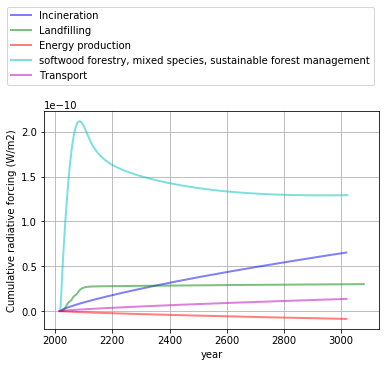

In [22]:
dict_res=timeline.characterize_dynamic_by_process("RadiativeForcing") #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

for k,v in dict_res.items():  
    plt.plot(v[0], v[1], 'b-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()

and each single flow

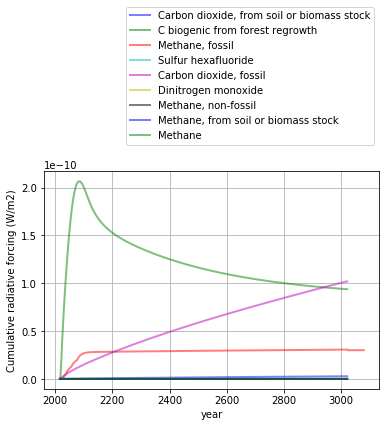

In [23]:
dict_res=timeline.characterize_dynamic_by_flow("RadiativeForcing") #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k'])

for k,v in dict_res.items():  
    plt.plot(v[0], v[1],linestyle= '-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()


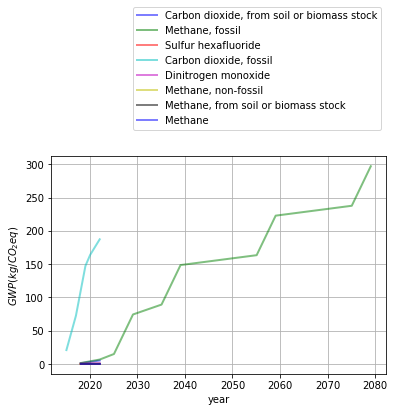

In [24]:
dict_res=timeline.characterize_static_by_flow(('IPCC 2013', 'climate change', 'GWP 100a')) #return a dictionary
colors = iter(['b', 'g', 'r', 'c', 'm', 'y', 'k','b', 'g', 'r', 'c', 'm', 'y', 'k'])
dict_res
for k,v in dict_res.items():  
    plt.plot(v[0], v[1], 'b-', lw=2, alpha=0.5,label=k,color=next(colors))

# # Format graph
plt.xlabel("year")
plt.ylabel("$GWP (kg/CO_{2}eq)$")
plt.grid(True)

plt.legend(bbox_to_anchor=(1,1.1), loc="lower right")
plt.show()

or look just at the impact of one single flow or activity returning their timeline first and characterizing time as in this example

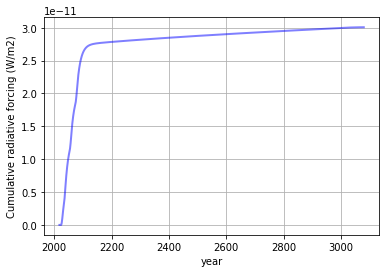

In [25]:
xs, ys=timeline.timeline_for_flow(METHANE).characterize_dynamic("RadiativeForcing")
plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)

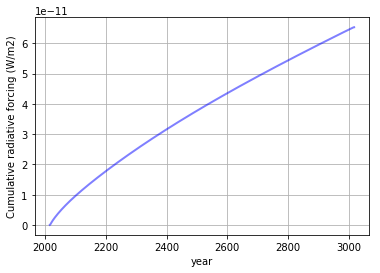

In [26]:
xs, ys=timeline.timeline_for_activity(('example', 'Incineration')).characterize_dynamic("RadiativeForcing")
plt.plot(xs, ys, 'b-', lw=2, alpha=0.5)

# Format graph
plt.xlabel("year")
plt.ylabel(r"Cumulative radiative forcing (W/m2)")
plt.grid(True)